In [1]:
from gnomepy.backtest.backtest import *
from gnomepy.backtest.strategy import *
from gnomepy.backtest.archive.signal import *
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import numpy as np
import multiprocessing as mp
from gnomepy.backtest.coint_testing import *


### Testing Cointegration Strategies

#### Load in Data from Client

In [2]:
client = MarketDataClient(bucket="gnome-market-data-dev", aws_profile_name="AWSAdministratorAccess-443370708724")
client_data_params = {
    "exchange_id": 3,
    "security_id": 1,
    "start_datetime": datetime.datetime(2025, 5, 21),
    "end_datetime": datetime.datetime(2025, 5, 22),
    "schema_type": SchemaType.MBP_10,
}
data_security3 = client.get_data(**client_data_params).to_df()
data_security3.head()

,exchangeId,securityId,timestampEvent,timestampSent,timestampRecv,price,size,action,side,flags,...,bidSize8,askSize8,bidCount8,askCount8,bidPrice9,askPrice9,bidSize9,askSize9,bidCount9,askCount9
0,1,3,2025-05-20 23:59:59.858000+00:00,NaT,2025-05-21 00:00:00.150020896+00:00,2525.8,0.7919,b'M',b'N',16,...,172.7827,77.6007,13,11,2524.9,2526.8,78.8793,80.0175,15,8
1,1,3,2025-05-21 00:00:00.146000+00:00,NaT,2025-05-21 00:00:03.992316355+00:00,2525.8,0.7919,b'M',b'N',16,...,172.7827,18.1617,13,10,2524.9,2526.8,83.7864,80.0175,15,8
2,1,3,2025-05-21 00:00:01.466000+00:00,NaT,2025-05-21 00:00:04.654344051+00:00,2525.8,0.7919,b'M',b'N',16,...,172.7827,76.0600,13,7,2524.9,2526.9,82.7837,105.2386,14,9
3,1,3,2025-05-21 00:00:01.065000+00:00,NaT,2025-05-21 00:00:04.654386238+00:00,2525.9,0.0296,b'T',b'B',16,...,172.7827,76.0600,13,7,2524.9,2526.9,82.7837,105.2386,14,9
4,1,3,2025-05-21 00:00:03.861000+00:00,NaT,2025-05-21 00:00:04.654396594+00:00,2525.9,0.0101,b'T',b'B',16,...,172.7827,76.0600,13,7,2524.9,2526.9,82.7837,105.2386,14,9


In [3]:
client = MarketDataClient(bucket="gnome-market-data-dev", aws_profile_name="AWSAdministratorAccess-443370708724")
client_data_params = {
    "exchange_id": 4,
    "security_id": 1,
    "start_datetime": datetime.datetime(2025, 5, 21),
    "end_datetime": datetime.datetime(2025, 5, 22),
    "schema_type": SchemaType.MBP_10,
}
data_security4 = client.get_data(**client_data_params).to_df()
data_security4.head()

,exchangeId,securityId,timestampEvent,timestampSent,timestampRecv,price,size,action,side,flags,...,bidSize8,askSize8,bidCount8,askCount8,bidPrice9,askPrice9,bidSize9,askSize9,bidCount9,askCount9
0,1,4,2025-05-20 23:59:59.858000+00:00,NaT,2025-05-21 00:00:00.098147342+00:00,168.63,0.35,b'M',b'N',16,...,276.46,438.65,10,4,168.55,168.74,409.890000,1008.46,8,9
1,1,4,2025-05-21 00:00:00.146000+00:00,NaT,2025-05-21 00:00:04.307389398+00:00,168.63,0.35,b'M',b'N',16,...,276.46,440.61,10,5,168.55,168.74,277.565408,918.07,11,8
2,1,4,2025-05-21 00:00:01.667000+00:00,NaT,2025-05-21 00:00:05.017902039+00:00,168.63,0.35,b'M',b'N',16,...,194.80,440.61,8,5,168.55,168.74,722.342704,933.11,7,9
3,1,4,2025-05-21 00:00:04.876000+00:00,NaT,2025-05-21 00:00:05.810204626+00:00,168.63,0.35,b'M',b'N',16,...,184.14,440.61,6,5,168.55,168.74,792.170000,431.57,5,8
4,1,4,2025-05-21 00:00:05.819000+00:00,NaT,2025-05-21 00:00:06.118878977+00:00,168.65,23.85,b'T',b'B',16,...,184.14,440.61,6,5,168.55,168.74,792.170000,431.57,5,8


In [4]:
# Join bidPrice0 from data_security4 onto data_security3 using the closest timestamp
# We'll use pandas.merge_asof for this purpose

# Ensure timestamps are sorted and in datetime format
data_security3 = data_security3.sort_values('timestampEvent')
data_security4 = data_security4.sort_values('timestampEvent')

# Perform asof merge to get bidPrice0 from security 4 matched to closest timestamp in security 3
data_security3 = pd.merge_asof(
    data_security3,
    data_security4[['timestampEvent', 'bidPrice0', 'askPrice0']],
    on='timestampEvent',
    direction='nearest',
    suffixes=('', '_security4')
)
# The new column will be 'bidPrice0_security4'


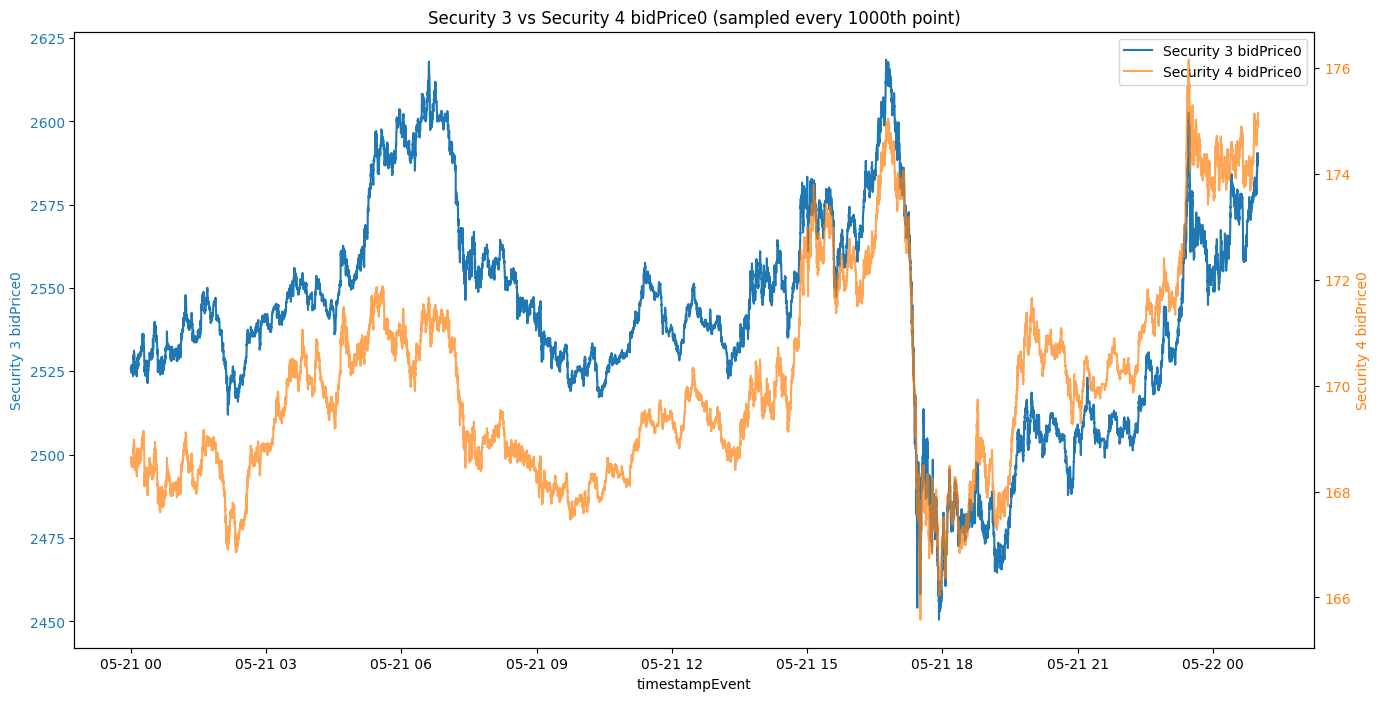

In [5]:
import matplotlib.pyplot as plt

# Sample every 1000th data point for plotting
sampled = data_security3.iloc[::10]

fig, ax1 = plt.subplots(figsize=(16, 8))

color1 = 'tab:blue'
ax1.set_xlabel('timestampEvent')
ax1.set_ylabel('Security 3 bidPrice0', color=color1)
ln1 = ax1.plot(sampled['timestampEvent'], sampled['bidPrice0'], label='Security 3 bidPrice0', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color2 = 'tab:orange'
ax2.set_ylabel('Security 4 bidPrice0', color=color2)
ln2 = ax2.plot(sampled['timestampEvent'], sampled['bidPrice0_security4'], label='Security 4 bidPrice0', color=color2, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends from both axes
lns = ln1 + ln2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='best')

plt.title('Security 3 vs Security 4 bidPrice0 (sampled every 1000th point)')
plt.show()


In [6]:
# client = MarketDataClient(bucket="gnome-market-data-dev", aws_profile_name="AWSAdministratorAccess-443370708724")
# client_data_params = {
#     "exchange_id": 1,
#     "security_id": 1,
#     "start_datetime": datetime.datetime(2025, 6, 7),
#     "end_datetime": datetime.datetime(2025, 6, 8),
#     "schema_type": SchemaType.MBP_10,
# }
# data = client.get_data(**client_data_params).to_df()
# data.head()

#### Manufacture Synthetic Signals

In [7]:
# # Calculate average spread between ask and bid
# avg_spread = (data['askPrice0'] - data['bidPrice0']).mean()

# # Create lagged signals with different lag lengths
# lag_lengths = [50, 10, 300]  # Short, medium and long lags
# n = len(data)

# # Initialize perturbed series with original prices (bidPrice0)
# data['bidPrice0_perturbed_1'] = data['bidPrice0'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0']/10)
# data['bidPrice0_perturbed_2'] = data['bidPrice0'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0']/10)
# data['bidPrice0_perturbed_3'] = data['bidPrice0'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0']/10)

# # Initialize perturbed ask prices by adding spread to perturbed bid prices
# data['askPrice0_perturbed_1'] = data['bidPrice0_perturbed_1'] + avg_spread
# data['askPrice0_perturbed_2'] = data['bidPrice0_perturbed_2'] + avg_spread
# data['askPrice0_perturbed_3'] = data['bidPrice0_perturbed_3'] + avg_spread

# # --- New: Create random normal walk and its perturbed versions ---
# # Create a random walk series
# data['bidPrice0_random_normal'] = np.cumsum(np.random.normal(size=len(data))) + 10000
# data['askPrice0_random_normal'] = data['bidPrice0_random_normal'] + avg_spread

# # Initialize perturbed versions of the random walk
# data['bidPrice0_random_normal_perturbed_1'] = data['bidPrice0_random_normal'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0_random_normal']/10)
# data['bidPrice0_random_normal_perturbed_2'] = data['bidPrice0_random_normal'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0_random_normal']/10)
# data['bidPrice0_random_normal_perturbed_3'] = data['bidPrice0_random_normal'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0_random_normal']/10)

# # Initialize random_normal_perturbed ask prices by adding spread to random_normal_perturbed bid prices
# data['askPrice0_random_normal_perturbed_1'] = data['bidPrice0_random_normal_perturbed_1'] + avg_spread
# data['askPrice0_random_normal_perturbed_2'] = data['bidPrice0_random_normal_perturbed_2'] + avg_spread
# data['askPrice0_random_normal_perturbed_3'] = data['bidPrice0_random_normal_perturbed_3'] + avg_spread

# # Generate random lag points for each series
# num_lags = n // 1000  # Create lags roughly every 1000 ticks
# lag_points = np.sort(np.random.choice(range(n-max(lag_lengths)), num_lags, replace=False))

# # Apply lags at random points for both bidPrice0 and bidPrice0_random_normal perturbed series
# for start_idx in lag_points:
#     # For each lag length (short, medium, long)
#     for i, lag in enumerate(lag_lengths, 1):
#         # --- For bidPrice0 perturbed series ---
#         lagged_bid_price = data['bidPrice0'].iloc[start_idx-lag:start_idx-lag+lag].values
#         lagged_ask_price = lagged_bid_price + avg_spread
#         data[f'bidPrice0_perturbed_{i}'].iloc[start_idx:start_idx+lag] = lagged_bid_price
#         data[f'askPrice0_perturbed_{i}'].iloc[start_idx:start_idx+lag] = lagged_ask_price

#         # --- For bidPrice0_random_normal perturbed series (bid and ask) ---
#         lagged_random_normal_bid = data['bidPrice0_random_normal'].iloc[start_idx-lag:start_idx-lag+lag].values
#         lagged_random_normal_ask = lagged_random_normal_bid + avg_spread
#         data[f'bidPrice0_random_normal_perturbed_{i}'].iloc[start_idx:start_idx+lag] = lagged_random_normal_bid
#         data[f'askPrice0_random_normal_perturbed_{i}'].iloc[start_idx:start_idx+lag] = lagged_random_normal_ask


# # Create divergent versions of bidPrice0_perturbed_1,2,3 and their corresponding ask prices, but add funky noise to the entire series
# for i in range(1, 4):
#     base_col = f'bidPrice0_perturbed_{i}'
#     new_bid_col = f'bidPrice0_perturbed_{i}_divergent'
#     new_ask_col = f'askPrice0_perturbed_{i}_divergent'
#     n = len(data)
#     split_idx = int(n * 0.55)
#     base_price = data[base_col].iloc[split_idx]
#     base_magnitude = 0.000001 * base_price

#     # --- Funky noise: sum of sinusoids with random frequencies, plus some random walk ---
#     t = np.arange(n)
#     num_sines = 3
#     funky_noise = np.zeros(n)
#     for j in range(num_sines):
#         freq = np.random.uniform(0.0005, 0.005)
#         phase = np.random.uniform(0, 2 * np.pi)
#         amplitude = np.random.uniform(0.0005, 0.002) * data[base_col].mean()
#         funky_noise += amplitude * np.sin(2 * np.pi * freq * t + phase)
#     # Add a small random walk component
#     funky_noise += np.cumsum(np.random.standard_t(df=3, size=n)) * (0.00005 * data[base_col].mean())

#     data[new_bid_col] = data[base_col] + funky_noise

#     # --- Exponential divergent sections after split_idx, with sign flips at random intervals ---
#     min_seg_len = int(0.05 * n)
#     max_seg_len = int(0.15 * n)
#     idx = split_idx
#     trend_sign = 1 if i % 2 == 1 else -1
#     exp_trend = np.zeros(n - split_idx)
#     pos = 0
#     while idx < n:
#         seg_len = np.random.randint(min_seg_len, max_seg_len + 1)
#         seg_end = min(idx + seg_len, n)
#         steps = np.arange(seg_end - idx)
#         # Exponential divergence: exp(a * step) - 1, with small a
#         a = trend_sign * np.random.uniform(0.00005, 0.00015)
#         exp_trend[pos:pos + len(steps)] = base_magnitude * (np.exp(a * steps) - 1)
#         trend_sign *= -1
#         idx = seg_end
#         pos += len(steps)
#     # Add the piecewise exponential trend to the series after split_idx
#     data.loc[data.index[split_idx:], new_bid_col] += exp_trend

#     # Create the corresponding ask price using avg_spread
#     data[new_ask_col] = data[new_bid_col] + avg_spread

#     # Calculate and store the log of the divergent bid price
#     data[f'log_price_perturbed_{i}_divergent'] = np.log(data[new_bid_col])

# # Calculate log of prices
# data['log_price'] = np.log(data['bidPrice0'])
# data['log_price_perturbed_1'] = np.log(data['bidPrice0_perturbed_1'])
# data['log_price_perturbed_2'] = np.log(data['bidPrice0_perturbed_2'])
# data['log_price_perturbed_3'] = np.log(data['bidPrice0_perturbed_3'])

# # Also calculate log of random normal and its perturbed versions
# data['log_price_random_normal'] = np.log(data['bidPrice0_random_normal'])
# data['log_price_random_normal_perturbed_1'] = np.log(data['bidPrice0_random_normal_perturbed_1'])
# data['log_price_random_normal_perturbed_2'] = np.log(data['bidPrice0_random_normal_perturbed_2'])
# data['log_price_random_normal_perturbed_3'] = np.log(data['bidPrice0_random_normal_perturbed_3'])

# # Drop NaN values from all columns used in plotting
# data = data.dropna(subset=[
#     'log_price', 'log_price_perturbed_1', 'log_price_perturbed_2', 'log_price_perturbed_3',
#     'log_price_random_normal', 'log_price_random_normal_perturbed_1', 'log_price_random_normal_perturbed_2', 'log_price_random_normal_perturbed_3'
# ], axis=0)

# # Display the log prices, plotting every 1000th point
# plt.figure(figsize=(14, 7))
# plt.plot(data['timestampEvent'][::1000], data['log_price'][::1000], label='Original Log Price', alpha=0.8)
# plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_1'][::1000], label='Perturbed 1% Log Price', alpha=0.8)
# plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_2'][::1000], label='Perturbed 2% Log Price', alpha=0.8)
# plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_3'][::1000], label='Perturbed 3% Log Price', alpha=0.8)
# # plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_1_divergent'][::1000], label='Perturbed 1% Log Price', alpha=0.8)
# # plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_2_divergent'][::1000], label='Perturbed 2% Log Price', alpha=0.8)
# # plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_3_divergent'][::1000], label='Perturbed 3% Log Price', alpha=0.8)
# # plt.plot(data['timestampEvent'][::1000], data['log_price_random_normal'][::1000], label='Random Normal Log Price', alpha=0.8, linestyle='--')
# # plt.plot(data['timestampEvent'][::1000], data['log_price_random_normal_perturbed_1'][::1000], label='Random Normal Perturbed 1', alpha=0.8, linestyle='--')
# # plt.plot(data['timestampEvent'][::1000], data['log_price_random_normal_perturbed_2'][::1000], label='Random Normal Perturbed 2', alpha=0.8, linestyle='--')
# # plt.plot(data['timestampEvent'][::1000], data['log_price_random_normal_perturbed_3'][::1000], label='Random Normal Perturbed 3', alpha=0.8, linestyle='--')
# plt.xlabel('Time')
# plt.ylabel('Log Price')
# plt.title('Log of Original, Perturbed, and Random Normal bidPrice0')
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.show()

#### Find Cointegrated Baskets

In [8]:
# seen_baskets, cointegrated_baskets = get_coint_baskets(
#     columns=[
#         'bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2', 'bidPrice0_perturbed_3',
#         'bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_1', 'bidPrice0_random_normal_perturbed_2', 'bidPrice0_random_normal_perturbed_3'
#             ], 
#     data=data, significance_level=0.01, min_basket_size=2
# )

seen_baskets, cointegrated_baskets = get_coint_baskets(
    columns=['bidPrice0', 'bidPrice0_security4'], 
    data=data_security3, significance_level=0.01, min_basket_size=2
)

Rank from test for basket ('bidPrice0', 'bidPrice0_security4'): 0


In [9]:
cointegrated_baskets[('bidPrice0', 'bidPrice0_security4')] = {}
cointegrated_baskets

{('bidPrice0', 'bidPrice0_security4'): {}}

#### Backtest Cointegration Baskets

In [54]:
# Get basksets from cointegration testing
baskets = list(cointegrated_baskets.keys())

# Your setup code here
results = main(
    baskets = baskets,
    data = data_security3,
    beta_refresh_freq = [5000, 10000],
    spread_window = [100, 1000],
    cash_start = [10000],
    notional = [100],
    trade_freq = [1],
    execution_delay = [0],
    enter_zscore = [2.0, 3.0, 6.0, 8.0],
    exit_zscore = [0.3],
    stop_loss_delta=[np.inf],
    retest_cointegration = [True, False],
    use_multiprocessing = False
)

backtest_results = {params['id']: {'history_df': history_df, 'trade_log': trade_log, 'params': params}
                    for params, history_df, trade_log in results}


/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:236: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=5000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=True


/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:236: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=5000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=False


/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:236: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=5000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=3.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=True


/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:236: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=5000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=3.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=False


/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:236: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=5000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=6.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=True


/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:236: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=5000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=6.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=False


/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:236: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=5000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=8.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=True


/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:236: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=5000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=8.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=False
Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=5000, spread_window=1000, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=True
Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=5000, spread_window=1000, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=False
Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=5000, spread_window=1000, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, e

/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:236: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=10000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=True


/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:236: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=10000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=False


/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:236: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=10000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=3.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=True


/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:236: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=10000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=3.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=False


/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:236: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=10000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=6.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=True


/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:236: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=10000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=6.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=False


/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:236: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=10000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=8.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=True


/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:236: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=10000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=8.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=False
Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=10000, spread_window=1000, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=True
Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=10000, spread_window=1000, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3, stop_loss_delta=inf, retest_cointegration=False
Complete backtest of basket: ('bidPrice0', 'bidPrice0_security4') with params: beta_refresh_freq=10000, spread_window=1000, cash_start=10000, notional=100, trade_freq=1, execution_delay=

#### Evaluate Cointegration Baskets

In [63]:
def compute_backtest_summary(history_df, trade_log, params):
    if trade_log.shape[0] == 0:
        summary = {
            'num_complete_trades': -1,
            'avg_profit_per_complete_trade': -1,
            'std_profit_per_complete_trade': -1,
            'total_profit': -1,
            'avg_ticks_per_complete_trade': -1,
            'std_ticks_per_complete_trade': -1,
            'win_ratio': -1,
            'max_drawdown': -1,
            'profit_factor': -1,
            'sharpe_ratio': -1
        }
        # Add params to summary
        for k, v in params.items():
            summary[k] = v
        return summary

    else:
        trade_log['cash_delta'] = trade_log['after_cash'] - trade_log['before_cash']

        # Only consider enter and exit trades for PL calculation, ignore extend trades
        enter_exit_mask = trade_log['action'].str.contains('enter|exit')
        enter_exit_trades = trade_log[enter_exit_mask].reset_index(drop=True)

        # Find indices of exit trades
        exit_mask = enter_exit_trades['action'].str.contains('exit')
        exit_indices = enter_exit_trades.index[exit_mask].tolist()

        # For each exit, find the immediately preceding enter (assume always alternates)
        pl_list, ticks_list, extends_list = [], [], []
         
        for exit_idx in exit_indices:
            # The enter trade is always the previous row before exit in enter_exit_trades
            enter_idx = exit_idx - 1
            if enter_idx >= 0 and 'enter' in enter_exit_trades.loc[enter_idx, 'action']:
                pl = enter_exit_trades.loc[exit_idx, 'after_cash'] - enter_exit_trades.loc[enter_idx, 'before_cash']
                pl_list.append(pl)
                # ticks_since_entry is on the exit trade
                ticks_list.append(enter_exit_trades.loc[exit_idx, 'ticks_since_entry'])
                extends_list.append(enter_exit_trades.loc[exit_idx, 'extends_since_entry'])
            else:
                # If for some reason the previous is not an enter, skip
                continue

        # Create a DataFrame for exit trades with calculated PL and ticks
        exit_trades = pd.DataFrame({
            'pl': pl_list,
            'ticks_since_entry': ticks_list,
            'extends_since_entry': extends_list
        })

        # Calculate max drawdown
        if 'after_cash' in trade_log.columns:
            running_max = trade_log[trade_log['action'].str.contains('exit')]['after_cash'].cummax()
            drawdown = trade_log[trade_log['action'].str.contains('exit')]['after_cash'] - running_max
            max_drawdown = drawdown.min()
        else:
            max_drawdown = np.nan

        # Calculate Sharpe ratio (using per-trade P&L)
        if len(exit_trades) > 1:
            mean_pl = exit_trades['pl'].mean()
            std_pl = exit_trades['pl'].std()
            sharpe_ratio = mean_pl / std_pl * np.sqrt(365) if std_pl != 0 else np.nan
        else:
            sharpe_ratio = np.nan

        summary = {
            'num_complete_trades': len(exit_trades),
            'avg_profit_per_complete_trade': exit_trades['pl'].mean(),
            'std_profit_per_complete_trade': exit_trades['pl'].std(),
            'total_profit': exit_trades['pl'].sum(),
            'avg_ticks_per_complete_trade': exit_trades['ticks_since_entry'].mean(),
            'std_ticks_per_complete_trade': exit_trades['ticks_since_entry'].std(),
            'avg_extends_per_complete_trade': exit_trades['extends_since_entry'].mean(),
            'std_extends_per_complete_trade': exit_trades['extends_since_entry'].std(),
            'win_ratio': exit_trades[exit_trades['pl'] > 0].shape[0] / len(exit_trades),
            'max_drawdown': max_drawdown,
            'profit_factor': exit_trades[exit_trades['pl'] > 0]['pl'].sum() / np.abs(exit_trades[exit_trades['pl'] < 0]['pl'].sum() ),
            'sharpe_ratio': sharpe_ratio,
            'profit_to_drawdown': exit_trades['pl'].sum() / abs(max_drawdown) if max_drawdown != 0 else np.nan
        }
        # # Add params to summary
        for k, v in params.items():
            summary[k] = v

        return summary

# Generate summary statistics for each basket
backtest_summaries = {}
for basket, result in backtest_results.items():
    history_df = result['history_df']
    trade_log = result['trade_log']
    params = result.get('params', {})
    summary = compute_backtest_summary(history_df, trade_log, params)
    backtest_summaries[str(basket)] = summary

# Optionally, display as DataFrame for easy viewing
import pandas as pd
summary_df = pd.DataFrame.from_dict(backtest_summaries, orient='index')

# Round all float columns to 3 decimals for display
float_cols = summary_df.select_dtypes(include=['float', 'float64']).columns
summary_df[float_cols] = summary_df[float_cols].round(3)

from IPython.display import display
import pandas as pd

with pd.option_context('display.max_rows', None):
    display(summary_df.sort_values(['profit_to_drawdown', 'sharpe_ratio'], ascending=False))


,num_complete_trades,avg_profit_per_complete_trade,std_profit_per_complete_trade,total_profit,avg_ticks_per_complete_trade,std_ticks_per_complete_trade,avg_extends_per_complete_trade,std_extends_per_complete_trade,win_ratio,max_drawdown,...,beta_refresh_freq,spread_window,cash_start,notional,trade_freq,execution_delay,enter_zscore,exit_zscore,stop_loss_delta,retest_cointegration
"('bidPrice0', 'bidPrice0_security4')_beta_refresh_freq=5000_spread_window=1000_cash_start=10000_notional=100_trade_freq=1_execution_delay=0_enter_zscore=6.0_exit_zscore=0.3_stop_loss_delta=inf_retest_cointegration=True",6,1.075,2.292,6.450,237.667,255.507,8.333,8.618,0.333,-0.045,...,5000,1000,10000,100,1,0,6.0,0.3,inf,True
"('bidPrice0', 'bidPrice0_security4')_beta_refresh_freq=10000_spread_window=1000_cash_start=10000_notional=100_trade_freq=1_execution_delay=0_enter_zscore=6.0_exit_zscore=0.3_stop_loss_delta=inf_retest_cointegration=True",9,0.395,0.630,3.553,371.111,421.392,9.000,8.958,0.556,-0.053,...,10000,1000,10000,100,1,0,6.0,0.3,inf,True
"('bidPrice0', 'bidPrice0_security4')_beta_refresh_freq=10000_spread_window=1000_cash_start=10000_notional=100_trade_freq=1_execution_delay=0_enter_zscore=6.0_exit_zscore=0.3_stop_loss_delta=inf_retest_cointegration=False",16,0.147,0.931,2.347,437.938,365.844,6.375,7.491,0.625,-0.053,...,10000,1000,10000,100,1,0,6.0,0.3,inf,False
"('bidPrice0', 'bidPrice0_security4')_beta_refresh_freq=10000_spread_window=1000_cash_start=10000_notional=100_trade_freq=1_execution_delay=0_enter_zscore=8.0_exit_zscore=0.3_stop_loss_delta=inf_retest_cointegration=True",5,0.121,0.151,0.606,275.400,269.812,4.200,4.207,0.600,-0.026,...,10000,1000,10000,100,1,0,8.0,0.3,inf,True
"('bidPrice0', 'bidPrice0_security4')_beta_refresh_freq=10000_spread_window=1000_cash_start=10000_notional=100_trade_freq=1_execution_delay=0_enter_zscore=8.0_exit_zscore=0.3_stop_loss_delta=inf_retest_cointegration=False",5,0.121,0.151,0.606,275.400,269.812,4.200,4.207,0.600,-0.026,...,10000,1000,10000,100,1,0,8.0,0.3,inf,False
"('bidPrice0', 'bidPrice0_security4')_beta_refresh_freq=5000_spread_window=1000_cash_start=10000_notional=100_trade_freq=1_execution_delay=0_enter_zscore=8.0_exit_zscore=0.3_stop_loss_delta=inf_retest_cointegration=True",3,0.147,0.275,0.440,301.333,341.973,5.333,5.508,0.333,-0.022,...,5000,1000,10000,100,1,0,8.0,0.3,inf,True
"('bidPrice0', 'bidPrice0_security4')_beta_refresh_freq=10000_spread_window=100_cash_start=10000_notional=100_trade_freq=1_execution_delay=0_enter_zscore=8.0_exit_zscore=0.3_stop_loss_delta=inf_retest_cointegration=True",259,0.011,0.041,2.858,48.737,46.002,0.147,0.365,0.680,-0.248,...,10000,100,10000,100,1,0,8.0,0.3,inf,True
"('bidPrice0', 'bidPrice0_security4')_beta_refresh_freq=10000_spread_window=100_cash_start=10000_notional=100_trade_freq=1_execution_delay=0_enter_zscore=3.0_exit_zscore=0.3_stop_loss_delta=inf_retest_cointegration=True",1630,0.038,0.277,61.141,53.718,45.352,4.917,4.552,0.700,-6.924,...,10000,100,10000,100,1,0,3.0,0.3,inf,True
"('bidPrice0', 'bidPrice0_security4')_beta_refresh_freq=10000_spread_window=100_cash_start=10000_notional=100_trade_freq=1_execution_delay=0_enter_zscore=2.0_exit_zscore=0.3_stop_loss_delta=inf_retest_cointegration=True",2780,0.084,0.804,234.544,50.027,45.774,12.503,11.022,0.717,-27.438,...,10000,100,10000,100,1,0,2.0,0.3,inf,True
"('bidPrice0', 'bidPrice0_security4')_beta_refresh_freq=10000_spread_window=100_cash_start=10000_notional=100_trade_freq=1_execution_delay=0_enter_zscore=6.0_exit_zscore=0.3_stop_loss_delta=inf_retest_cointegration=True",418,0.015,0.071,6.426,52.517,45.124,0.856,0.934,0.696,-0.788,...,10000,100,10000,100,1,0,6.0,0.3,inf,True


In [50]:
0.00045*1000*3351

1507.95

In [69]:
with pd.option_context('display.max_rows', None):
    # Group by basket, beta_refresh_freq, spread_window, and execution_delay, then display the mean sharpe_ratio and count for each group
    group_cols = ['basket', 'beta_refresh_freq', 'spread_window', 'enter_zscore', 'exit_zscore', 'stop_loss_delta', 'retest_cointegration'] 

    if all(col in summary_df.columns for col in group_cols):
        grouped = summary_df.groupby(group_cols).agg(
            sharpe_ratio=('sharpe_ratio', 'mean'),
            profit_factor=('profit_factor', 'mean'),
            win_ratio=('win_ratio', 'mean'),
            max_drawdown=('max_drawdown', 'mean'),
            total_profit_sum=('total_profit', 'sum'),
            avg_profit_per_complete_trade=('avg_profit_per_complete_trade', 'mean'),
            std_profit_per_complete_trade=('std_profit_per_complete_trade', 'mean'),
            profit_to_drawdown=('profit_to_drawdown', 'mean'),
            num_complete_trades=('num_complete_trades', 'mean')
        ).sort_values(['basket', 'profit_to_drawdown', 'sharpe_ratio'], ascending=[True, False, False])

        display(grouped)
        
    else:
        display(summary_df)



sharpe_ratio  \
basket                           beta_refresh_freq spread_window enter_zscore exit_zscore stop_loss_delta retest_cointegration                 
(bidPrice0, bidPrice0_security4) 5000              1000          6.0          0.3         inf             True                         8.959   
                                 10000             1000          6.0          0.3         inf             True                        11.976   
                                                                                                          False                        3.009   
                                                                 8.0          0.3         inf             False                       15.301   
                                                                                                          True                        15.301   
                                 5000              1000          8.0          0.3         inf             True                        10.211   
                                 10000             100           8.0          0.3         inf             True                         5.145   
                                                                 3.0          0.3         inf             True                         2.588   
                                                                 2.0          0.3         inf             True                         2.004   
                                                                 6.0          0.3         inf             True                         4.135   
                                                   1000          3.0          0.3         inf             True                         4.592   
                                                   100           8.0          0.3         inf             False                        3.310   
                                                                 2.0          0.3         inf             False                        1.514   
                                 5000              100           8.0          0.3         inf             False                        3.118   
                                 10000             100           6.0          0.3         inf             False                        2.900   
                                 5000              100           6.0          0.3         inf             False                        2.554   
                                                                 3.0          0.3         inf             False                        1.230   
                                                   1000          6.0          0.3         inf             False                        1.536   
                                                   100           2.0          0.3         inf             False                        0.896   
                                 10000             100           3.0          0.3         inf             False                        1.470   
                                 5000              100           8.0          0.3         inf             True                         3.944   
                                 10000             1000          2.0          0.3         inf             False                        1.693   
                                 5000              100           6.0          0.3         inf             True                         2.935   
                                                                 2.0          0.3         inf             True                         1.010   
                                 10000             1000          2.0          0.3         inf             True                         1.978   
                                 5000              1000          2.0          0.3         inf             True                         1.449   
                                                                                                

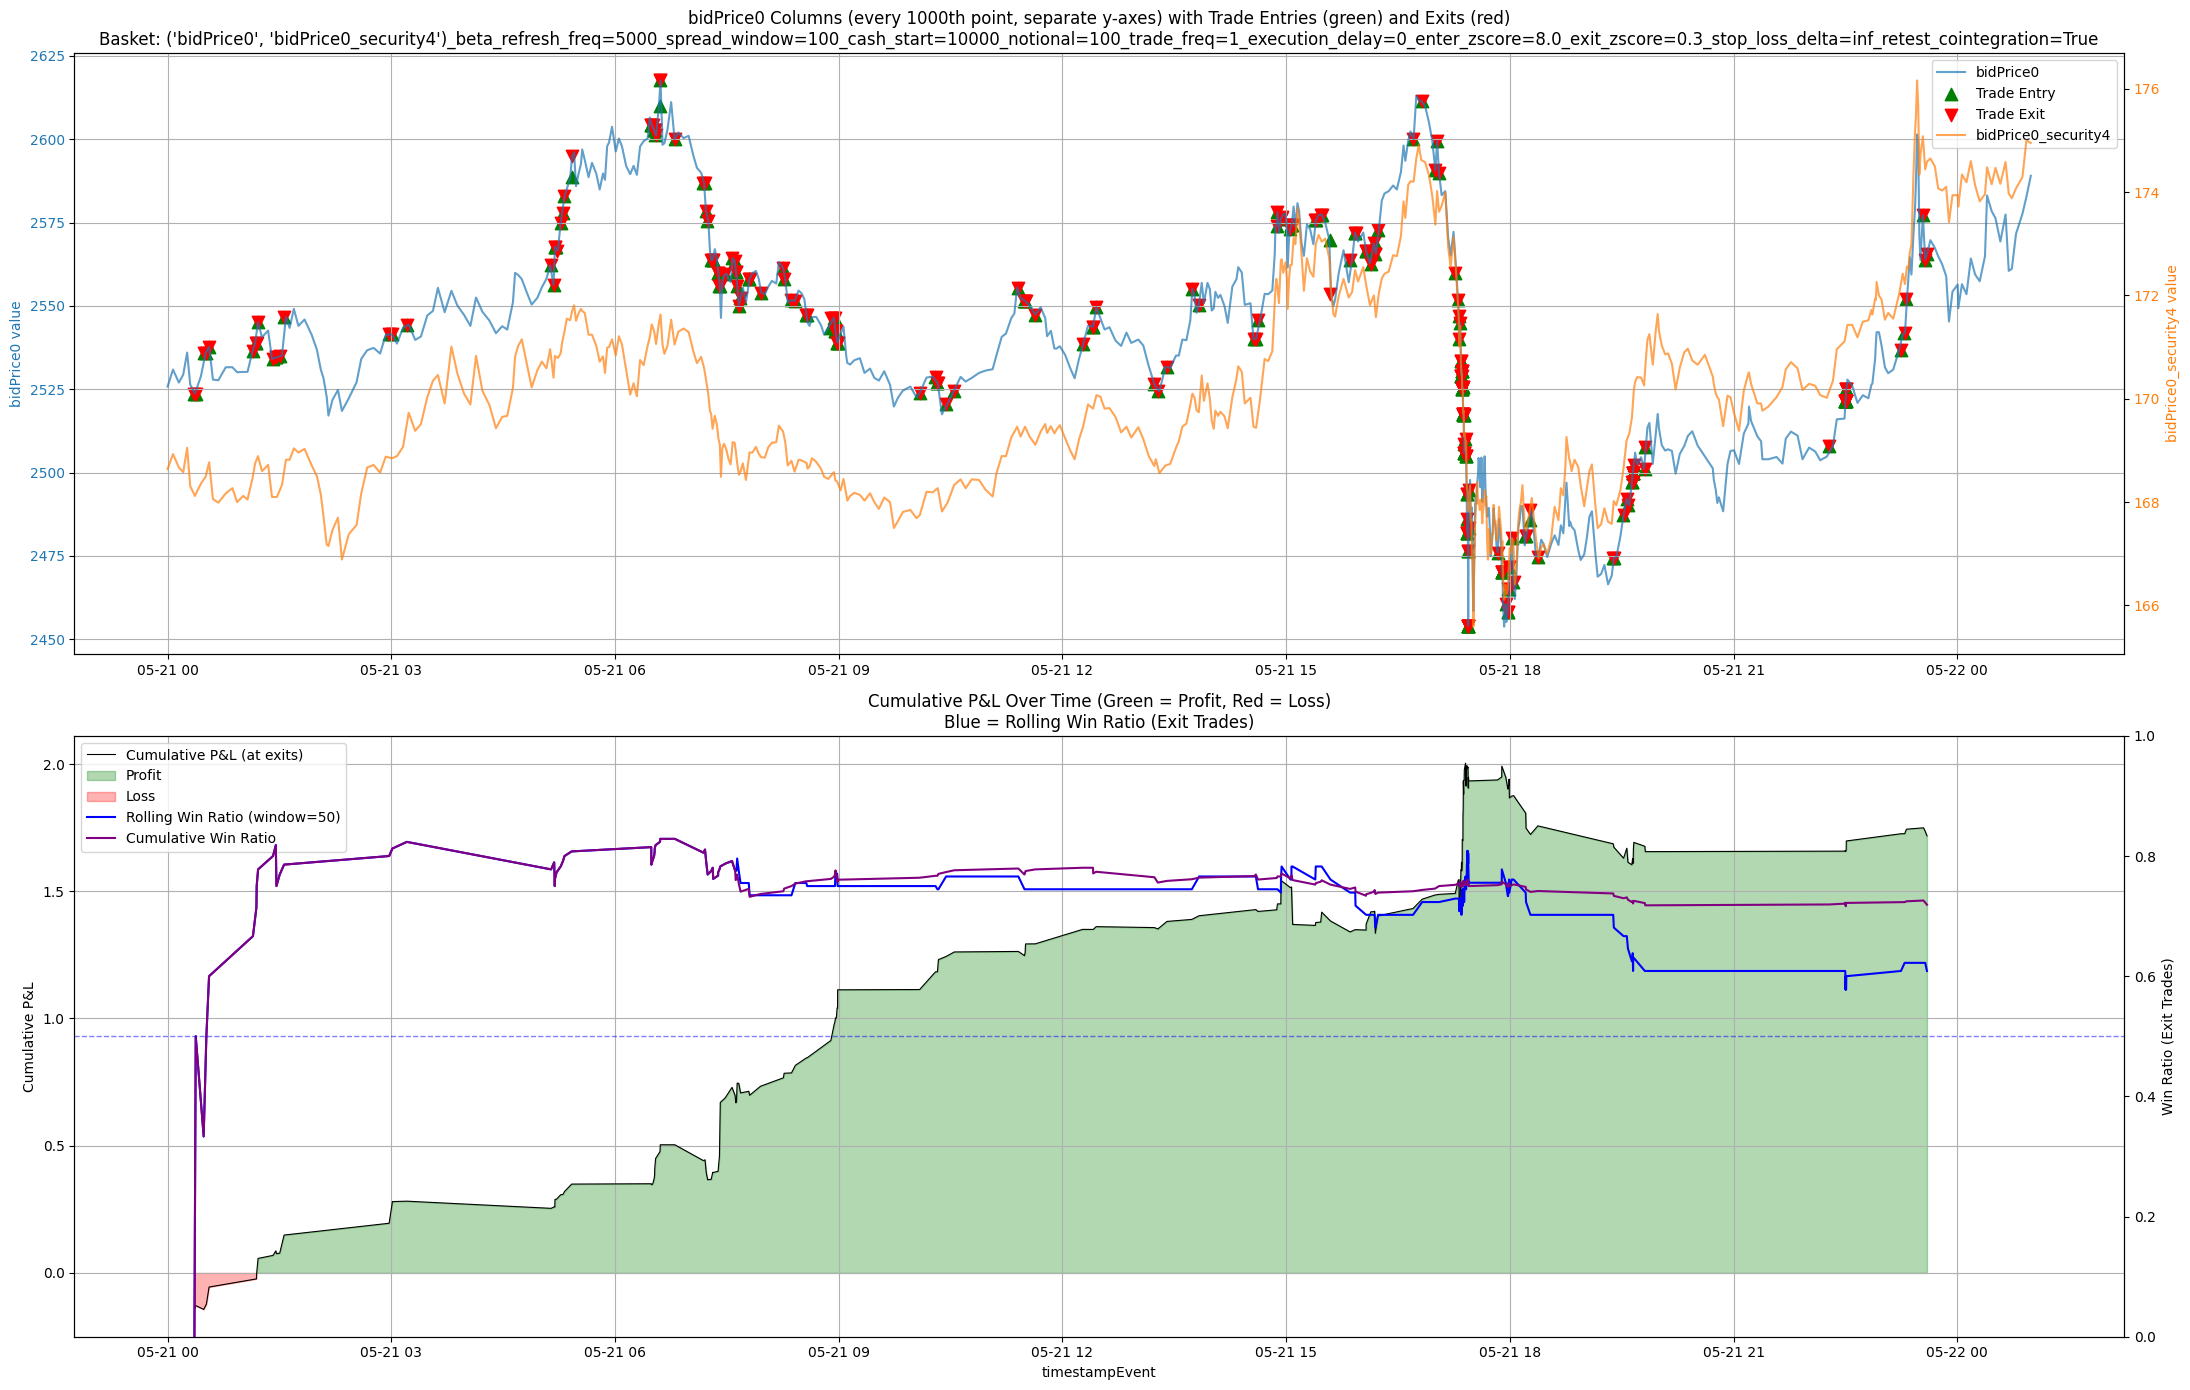

In [74]:
import matplotlib.pyplot as plt

def plot_bidprice0_and_trades(index):
    """
    Plots bidPrice0 columns and trade entries/exits for the basket at the given index in backtest_results.
    The basket key is included in the plot title.
    Each bidPrice0 column is plotted on its own y-axis (different scales).
    """
    # Get the basket's results at the given index
    basket_keys = list(backtest_results.keys())
    basket_key = basket_keys[index]
    result = backtest_results[basket_key]
    history_df = result['history_df']
    trade_log = result['trade_log']

    # Find all columns with "bidPrice0" in their name
    bid_cols = [col for col in history_df.columns if "bidPrice0" in col]

    # Plot every 1000th datapoint for all bidPrice0 columns against timestampEvent
    step = 1000
    sampled_idx = np.arange(0, len(history_df), step)

    # Make the second graph (ax2) larger both vertically and horizontally
    # We'll use gridspec to allocate more space to ax2, and increase the overall figure size
    fig = plt.figure(figsize=(22, 14))  # Larger figure
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 3])  # Make ax2 as tall as ax1

    # --- First graph: prices on different y-axes (scales) ---
    ax1 = fig.add_subplot(gs[0])
    axes = [ax1]
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # Plot the first bidPrice0 column on ax1
    if bid_cols:
        col = bid_cols[0]
        ax1.plot(
            history_df['timestampEvent'].iloc[sampled_idx],
            history_df[col].iloc[sampled_idx],
            label=col,
            color=color_cycle[0],
            alpha=0.7
        )
        ax1.set_ylabel(f'{col} value', color=color_cycle[0])
        ax1.tick_params(axis='y', labelcolor=color_cycle[0])
    # Plot additional bidPrice0 columns on their own y-axes
    for i, col in enumerate(bid_cols[1:], 1):
        ax_new = ax1.twinx()
        # Offset the spine to avoid overlap
        ax_new.spines["right"].set_position(("axes", 1 + 0.1 * (i-1)))
        # Make patch invisible (for clean overlay)
        ax_new.set_frame_on(True)
        ax_new.patch.set_visible(False)
        color = color_cycle[i % len(color_cycle)]
        ax_new.plot(
            history_df['timestampEvent'].iloc[sampled_idx],
            history_df[col].iloc[sampled_idx],
            label=col,
            color=color,
            alpha=0.7
        )
        ax_new.set_ylabel(f'{col} value', color=color)
        ax_new.tick_params(axis='y', labelcolor=color)
        axes.append(ax_new)

    # Mark trade entries and exits (on the closest sampled timestamp)
    if trade_log is not None and not trade_log.empty:
        # Find entry and exit indices
        entry_mask = trade_log['action'].str.contains('enter', case=False)
        exit_mask = trade_log['action'].str.contains('exit', case=False)
        # For each entry/exit, find the closest sampled timestamp in history_df
        def get_closest_sampled_value(ts_list, col):
            # For each ts in ts_list, find the closest in sampled_idx
            values = []
            for ts in ts_list:
                # Find the index in history_df where timestampEvent == ts
                idx = history_df.index[history_df['timestampEvent'] == ts]
                if len(idx) == 0:
                    values.append(None)
                    continue
                idx = idx[0]
                # Find the closest sampled index
                closest_sampled = sampled_idx[np.abs(sampled_idx - idx).argmin()]
                values.append(history_df.loc[closest_sampled, col])
            return values

        # Plot entry/exit points for the first bidPrice0 column only (for clarity)
        entry_y = get_closest_sampled_value(trade_log.loc[entry_mask, 'timestampEvent'], bid_cols[0])
        exit_y = get_closest_sampled_value(trade_log.loc[exit_mask, 'timestampEvent'], bid_cols[0])
        ax1.scatter(
            trade_log.loc[entry_mask, 'timestampEvent'],
            entry_y,
            color='green', marker='^', s=80, label='Trade Entry'
        )
        ax1.scatter(
            trade_log.loc[exit_mask, 'timestampEvent'],
            exit_y,
            color='red', marker='v', s=80, label='Trade Exit'
        )

    # Compose a combined legend for all price axes
    handles, labels = [], []
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        handles += h
        labels += l
    # Remove duplicate labels
    from collections import OrderedDict
    by_label = OrderedDict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys(), loc='best')

    ax1.set_title(f'bidPrice0 Columns (every 1000th point, separate y-axes) with Trade Entries (green) and Exits (red)\nBasket: {basket_key}')
    ax1.grid(True)

    # --- Second graph: Cumulative P&L ---
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # # Add vertical black dotted lines at timestamps where beta_refresh_vector_timestamp changes
    # if trade_log is not None and 'last_beta_vector_refresh' in trade_log.columns:
    #     # Find where the value changes (including the first value)
    #     beta_refresh_ts = trade_log['last_beta_vector_refresh']
    #     change_mask = beta_refresh_ts != beta_refresh_ts.shift(1)
    #     change_indices = trade_log.index[change_mask]
    #     change_timestamps = trade_log.loc[change_indices, 'timestampEvent']
    #     for ts in change_timestamps:
    #         ax2.axvline(ts, color='blue', linestyle=':', linewidth=1, alpha=0.7, label='_nolegend_')

    # Fast and visually clear cumulative P&L area chart
    if trade_log is not None and not trade_log.empty:
        trade_log = trade_log.copy()

        # --- Updated cumulative PL logic (from file_context_0) ---
        # Only consider enter and exit trades for PL calculation, ignore extend trades
        enter_exit_mask = trade_log['action'].str.contains('enter|exit', case=False)
        enter_exit_trades = trade_log[enter_exit_mask].reset_index(drop=True)

        # Find indices of exit trades
        exit_mask = enter_exit_trades['action'].str.contains('exit', case=False)
        exit_indices = enter_exit_trades.index[exit_mask].tolist()

        # For each exit, find the immediately preceding enter (assume always alternates)
        pl_list = []
        ticks_list = []
        for exit_idx in exit_indices:
            enter_idx = exit_idx - 1
            if enter_idx >= 0 and 'enter' in enter_exit_trades.loc[enter_idx, 'action']:
                pl = enter_exit_trades.loc[exit_idx, 'after_cash'] - enter_exit_trades.loc[enter_idx, 'before_cash']
                pl_list.append(pl)
                ticks_list.append(enter_exit_trades.loc[exit_idx, 'ticks_since_entry'])
            else:
                continue

        # Create a DataFrame for exit trades with calculated PL and ticks
        exit_trades = pd.DataFrame({
            'pl': pl_list,
            'ticks_since_entry': ticks_list
        })

        # For cumulative PL over time, reconstruct a time series using only exit trades
        # We'll plot cumulative sum of per-trade PL at the timestamp of each exit trade
        # Get the timestamps of exit trades from the original trade_log
        exit_trade_mask = trade_log['action'].str.contains('exit', case=False)
        exit_trade_timestamps = trade_log.loc[exit_trade_mask, 'timestampEvent'].values

        # Defensive: If number of exit_trades doesn't match number of exit_trade_timestamps, align to min length
        min_len = min(len(exit_trades), len(exit_trade_timestamps))
        cum_pl = pd.Series(exit_trades['pl'][:min_len]).cumsum().values
        timestamps = exit_trade_timestamps[:min_len]

        # Plot the cumulative P&L as a line (at exit trade timestamps)
        ax2.plot(timestamps, cum_pl, color='black', linewidth=0.8, label='Cumulative P&L (at exits)')

        # Fill area: green where cum_pl >= 0, red where cum_pl < 0
        ax2.fill_between(
            timestamps,
            cum_pl,
            0,
            where=(cum_pl >= 0),
            interpolate=True,
            color='green',
            alpha=0.3,
            label='Profit'
        )
        ax2.fill_between(
            timestamps,
            cum_pl,
            0,
            where=(cum_pl < 0),
            interpolate=True,
            color='red',
            alpha=0.3,
            label='Loss'
        )

        # --- Rolling win ratio for exit trades ---
        # A win is pl > 0, a loss is pl < 0, ignore pl == 0
        exit_trades['is_win'] = exit_trades['pl'] > 0
        exit_trades['is_loss'] = exit_trades['pl'] < 0

        # Rolling window size (number of exit trades)
        win_ratio_window = 50  # You can adjust this window size

        # Compute rolling win ratio (number of wins / (wins + losses)) for exit trades
        # Use min_periods=1 so the ratio is defined at the start
        rolling_wins = exit_trades['is_win'].rolling(window=win_ratio_window, min_periods=1).sum()
        rolling_losses = exit_trades['is_loss'].rolling(window=win_ratio_window, min_periods=1).sum()
        rolling_win_ratio = rolling_wins / (rolling_wins + rolling_losses)

        # Also compute cumulative win ratio (all time up to each point)
        cumulative_wins = exit_trades['is_win'].cumsum()
        cumulative_losses = exit_trades['is_loss'].cumsum()
        cumulative_win_ratio = cumulative_wins / (cumulative_wins + cumulative_losses)
        # For plotting, use the exit trade timestamps
        exit_timestamps = timestamps

        # Plot the rolling win ratio and cumulative win ratio on a secondary y-axis
        ax2b = ax2.twinx()
        ax2b.plot(
            exit_timestamps,
            rolling_win_ratio,
            color='blue',
            linewidth=1.5,
            label=f'Rolling Win Ratio (window={win_ratio_window})'
        )
        ax2b.plot(
            exit_timestamps,
            cumulative_win_ratio,
            color='purple',
            linewidth=1.5,
            linestyle='-',
            label='Cumulative Win Ratio'
        )
        ax2b.set_ylabel('Win Ratio (Exit Trades)')
        ax2b.set_ylim(0, 1)
        ax2b.grid(False)
        # Add a horizontal line at 0.5 for reference
        ax2b.axhline(0.5, color='blue', linestyle='--', linewidth=1, alpha=0.5, label='_nolegend_')

        # Compose a combined legend for both axes
        handles1, labels1 = ax2.get_legend_handles_labels()
        handles2, labels2 = ax2b.get_legend_handles_labels()
        from collections import OrderedDict
        by_label = OrderedDict(zip(labels1 + labels2, handles1 + handles2))
        ax2.legend(by_label.values(), by_label.keys(), loc='best')

        ax2.set_ylabel('Cumulative P&L')
        ax2.set_title('Cumulative P&L Over Time (Green = Profit, Red = Loss)\nBlue = Rolling Win Ratio (Exit Trades)')
        ax2.grid(True)

    ax2.set_xlabel('timestampEvent')
    plt.tight_layout()
    plt.show()

# Find the index corresponding to the desired key
target_key = "('bidPrice0', 'bidPrice0_security4')_beta_refresh_freq=5000_spread_window=100_cash_start=10000_notional=100_trade_freq=1_execution_delay=0_enter_zscore=8.0_exit_zscore=0.3_stop_loss_delta=inf_retest_cointegration=True"
keys_list = list(backtest_results.keys())
index = keys_list.index(target_key)
plot_bidprice0_and_trades(index=index)

In [68]:
trade_log

,step,timestampEvent,last_beta_vector_refresh,action,before_cash,after_cash,price_vector,before_position,after_position,before_position_value,after_position_value,z_score,ticks_since_entry,extends_since_entry,cash_delta
0,363603,2025-05-21 17:23:12.862,2025-05-21 17:22:07.548,enter_long,10000.000000,10093.659306,"[2507.6, 169.26]","[0.0, 0.0]","[0.0024530710067553014, -0.5896882130913096]",0.000000,-93.659306,-15.123108,0,0,93.659306
1,363604,2025-05-21 17:23:13.064,2025-05-21 17:22:07.548,extend_long,10093.659306,10187.318612,"[2507.6, 169.26]","[0.0024530710067553014, -0.5896882130913096]","[0.004906142013510603, -1.1793764261826192]",-93.659306,-187.318612,-13.634383,1,1,93.659306
2,363605,2025-05-21 17:23:13.141,2025-05-21 17:22:07.548,extend_long,10187.318612,10280.977918,"[2507.6, 169.26]","[0.004906142013510603, -1.1793764261826192]","[0.007359213020265904, -1.7690646392739287]",-187.318612,-280.977918,-12.511424,2,2,93.659306
3,363606,2025-05-21 17:23:13.265,2025-05-21 17:22:07.548,extend_long,10280.977918,10374.637224,"[2507.6, 169.26]","[0.007359213020265904, -1.7690646392739287]","[0.009812284027021206, -2.3587528523652384]",-280.977918,-374.637224,-11.625298,3,3,93.659306
4,363607,2025-05-21 17:23:13.265,2025-05-21 17:22:07.548,extend_long,10374.637224,10468.296530,"[2507.6, 169.26]","[0.009812284027021206, -2.3587528523652384]","[0.012265355033776508, -2.948441065456548]",-374.637224,-468.296530,-10.902881,4,4,93.659306
5,363608,2025-05-21 17:23:13.265,2025-05-21 17:22:07.548,extend_long,10468.296530,10561.955837,"[2507.6, 169.26]","[0.012265355033776508, -2.948441065456548]","[0.01471842604053181, -3.5381292785478577]",-468.296530,-561.955837,-10.306461,5,5,93.659306
6,363609,2025-05-21 17:23:13.265,2025-05-21 17:22:07.548,exit_long,10561.955837,9999.998528,"[2507.5, 169.26]","[0.01471842604053181, -3.5381292785478577]","[0.0, 0.0]",-561.957308,0.000000,-0.103554,6,5,-561.957308
7,372892,2025-05-21 17:26:30.146,2025-05-21 17:25:35.125,enter_long,9999.998528,10094.410254,"[2485.7, 168.13]","[0.0, 0.0]","[0.0021885931151068828, -0.593897057256887]",0.000000,-94.411726,-15.687387,0,0,94.411726
8,372893,2025-05-21 17:26:30.146,2025-05-21 17:25:35.125,extend_long,10094.410254,10188.821981,"[2485.7, 168.13]","[0.0021885931151068828, -0.593897057256887]","[0.0043771862302137655, -1.187794114513774]",-94.411726,-188.823453,-14.056055,1,1,94.411726
9,372894,2025-05-21 17:26:30.146,2025-05-21 17:25:35.125,extend_long,10188.821981,10283.233707,"[2485.7, 168.13]","[0.0043771862302137655, -1.187794114513774]","[0.006565779345320648, -1.7816911717706612]",-188.823453,-283.235179,-12.844455,2,2,94.411726


In [ ]:
# Let's examine the trade_log for exit trades that ended up as losses and look for patterns.

import pandas as pd

# Get the trade_log DataFrame for the selected backtest result
trade_log = backtest_results[target_key]['trade_log']

# Filter for exit trades (side == 'exit')
exit_trades = trade_log[trade_log['action'].str.contains('exit')].copy()

# Add a column to indicate if the trade was a loss
exit_trades['is_loss'] = exit_trades['pnl'] < 0

# Show some basic stats
num_losses = exit_trades['is_loss'].sum()
num_exits = len(exit_trades)
print(f"Number of exit trades: {num_exits}")
print(f"Number of losing exit trades: {num_losses} ({num_losses/num_exits:.2%})")

# Show the first few losing trades
print("\nFirst 5 losing exit trades:")
print(exit_trades[exit_trades['is_loss']].head())

# Let's look for patterns in the losing trades.
# For example, check the distribution of z_score at exit, holding time, and entry/exit timestamps.

# 1. Distribution of z_score at exit for losing trades
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.hist(exit_trades[exit_trades['is_loss']]['z_score'], bins=50, color='red', alpha=0.7, label='Losing Trades')
plt.hist(exit_trades[~exit_trades['is_loss']]['z_score'], bins=50, color='green', alpha=0.5, label='Winning Trades')
plt.xlabel('z_score at exit')
plt.ylabel('Count')
plt.title('Distribution of z_score at Exit (Losses vs Wins)')
plt.legend()
plt.show()

# 2. Distribution of holding time for losing trades
if 'holding_time' in exit_trades.columns:
    plt.figure(figsize=(10, 4))
    plt.hist(exit_trades[exit_trades['is_loss']]['holding_time'], bins=50, color='red', alpha=0.7, label='Losing Trades')
    plt.hist(exit_trades[~exit_trades['is_loss']]['holding_time'], bins=50, color='green', alpha=0.5, label='Winning Trades')
    plt.xlabel('Holding Time (seconds)')
    plt.ylabel('Count')
    plt.title('Distribution of Holding Time (Losses vs Wins)')
    plt.legend()
    plt.show()
else:
    print("No 'holding_time' column in trade_log.")

# 3. Time of day or timestamp patterns
exit_trades['hour'] = pd.to_datetime(exit_trades['timestampEvent']).dt.hour
plt.figure(figsize=(10, 4))
plt.hist(exit_trades[exit_trades['is_loss']]['hour'], bins=24, color='red', alpha=0.7, label='Losing Trades')
plt.hist(exit_trades[~exit_trades['is_loss']]['hour'], bins=24, color='green', alpha=0.5, label='Winning Trades')
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Count')
plt.title('Exit Trade Hour of Day (Losses vs Wins)')
plt.legend()
plt.show()

# 4. Show summary statistics for losing trades
print("\nSummary statistics for losing exit trades:")
print(exit_trades[exit_trades['is_loss']][['pnl', 'z_score'] + (['holding_time'] if 'holding_time' in exit_trades.columns else [])].describe())


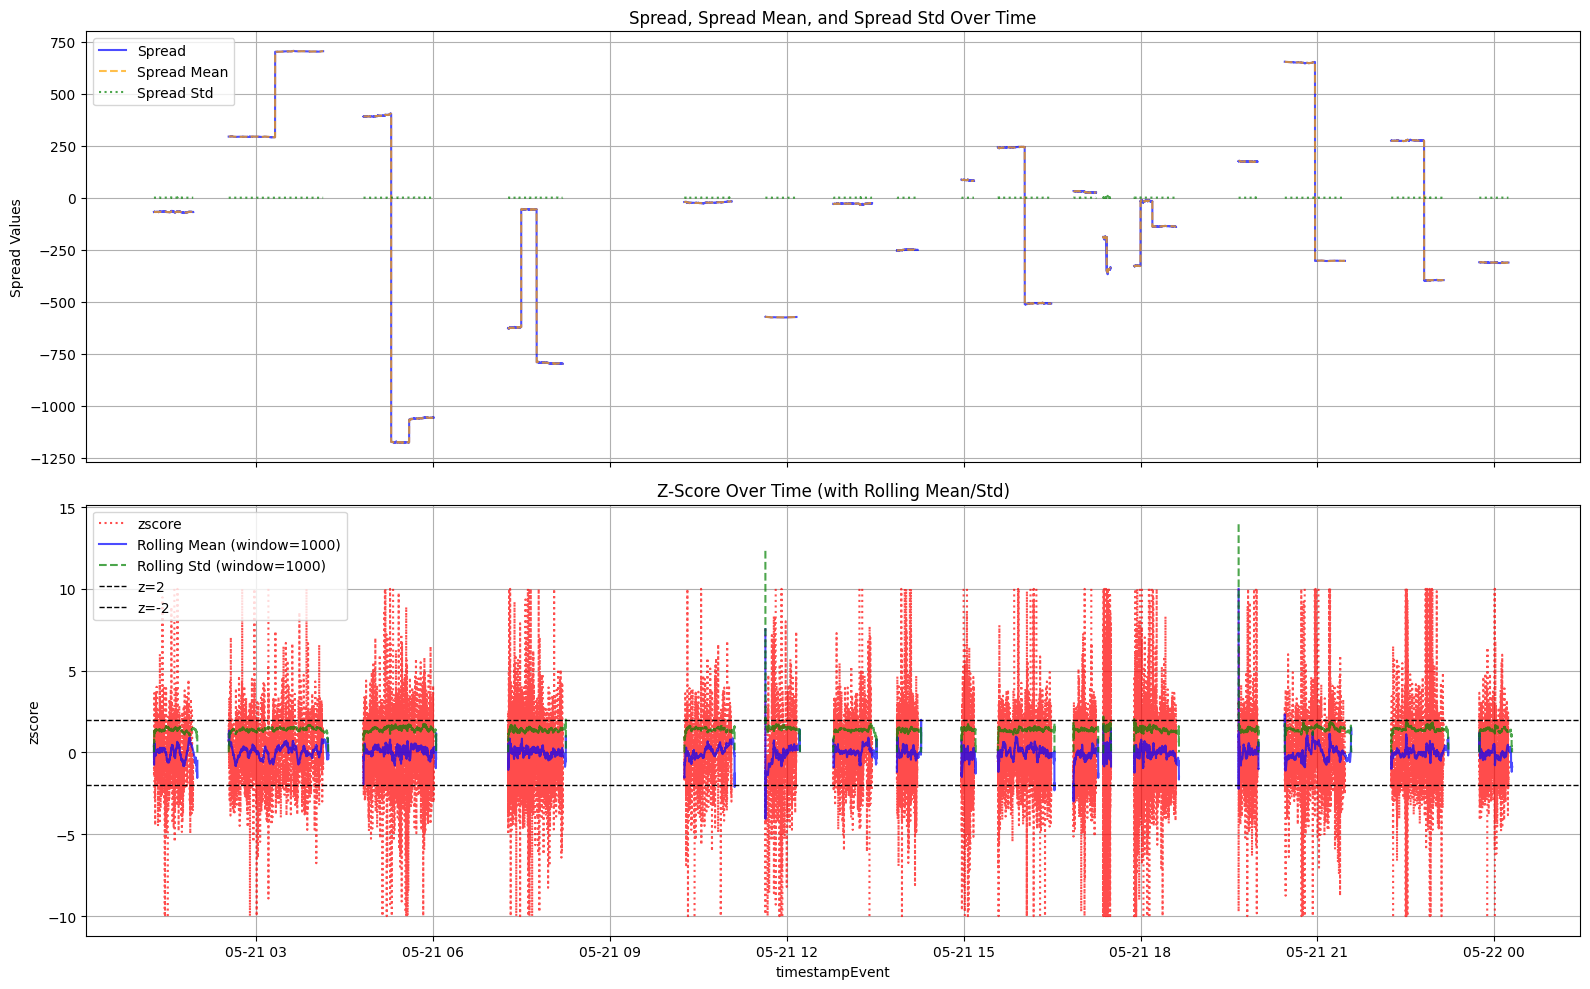

In [19]:
import matplotlib.pyplot as plt

def plot_spread_and_zscore(index):
    history_df = backtest_results[list(backtest_results.keys())[index]]['history_df']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

    # Plot spread, mean, std on ax1
    ax1.plot(history_df['timestampEvent'], history_df['spread'], label='Spread', color='blue', alpha=0.7)
    ax1.plot(history_df['timestampEvent'], history_df['spread_mean'], label='Spread Mean', color='orange', linestyle='--', alpha=0.7)
    ax1.plot(history_df['timestampEvent'], history_df['spread_std'], label='Spread Std', color='green', linestyle=':', alpha=0.7)
    ax1.set_ylabel('Spread Values')
    ax1.set_title('Spread, Spread Mean, and Spread Std Over Time')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Display rolling mean and std of z_score
    window = 1000  # You can adjust the window size as needed
    zscore_rolling_mean = history_df['z_score'].rolling(window=window, min_periods=1).mean()
    zscore_rolling_std = history_df['z_score'].rolling(window=window, min_periods=1).std()

    # Plot zscore and its rolling mean/std on ax2
    ax2.plot(history_df['timestampEvent'], history_df['z_score'], label='zscore', color='red', linestyle=':', alpha=0.7)
    ax2.plot(history_df['timestampEvent'], zscore_rolling_mean, label=f'Rolling Mean (window={window})', color='blue', linestyle='-', alpha=0.7)
    ax2.plot(history_df['timestampEvent'], zscore_rolling_std, label=f'Rolling Std (window={window})', color='green', linestyle='--', alpha=0.7)
    ax2.axhline(y=2, color='black', linestyle='--', linewidth=1, alpha=0.99, label='z=2')
    ax2.axhline(y=-2, color='black', linestyle='--', linewidth=1, alpha=0.99, label='z=-2')
    ax2.set_ylabel('zscore')
    ax2.set_xlabel('timestampEvent')
    ax2.set_title('Z-Score Over Time (with Rolling Mean/Std)')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_spread_and_zscore(index)